In [1]:
from tqdm import tqdm
import os
import pickle
import numpy as np

Model - Feature Extraction

In [2]:
from keras import Model
from keras.applications.vgg16 import VGG16, preprocess_input

In [82]:
fe_model = VGG16()
fe_model = Model(inputs=fe_model.inputs, outputs=fe_model.layers[-2].output)
fe_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Extracting Image Features

In [3]:
from keras_preprocessing.image import load_img, img_to_array

In [41]:
images_path = ''

In [16]:
features = {}

for img_name in tqdm(os.listdir(images_path)):
    img_path = images_path + '/' + img_name
    img = load_img(img_path, target_size=(224, 224, 3))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    feature = fe_model.predict(img, verbose=0)
    img_id = img_name.split('.')[0]
    features[img_id] = feature

100%|██████████| 8091/8091 [26:59<00:00,  5.00it/s]


Saving and loading saved features

In [10]:
features_path = ''

In [ ]:
pickle.dump(features, open(os.path.join(features_path, 'features.pkl'), 'wb'))

In [11]:
with open(os.path.join(features_path, 'features.pkl'), 'rb') as f:features = pickle.load(f)

Mapping images and corresponding captions

In [14]:
captions_path = ''

In [15]:
with open(captions_path, 'r') as f:
    next(f)
    captions_doc = f.read()

In [16]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')

    if len(line) < 2:
        continue
    
    img_id, caption = tokens[0], tokens[1:]
    img_id = img_id.split('.')[0]
    caption = ' '.join(caption)

    if img_id not in mapping:
        mapping[img_id] = []
    
    mapping[img_id].append(caption)


100%|██████████| 40456/40456 [00:00<00:00, 457821.75it/s]


In [17]:
len(mapping)

8091

Preprocessing captions

In [18]:
def clean(mapping):
    for img_id, captions in tqdm(mapping.items()):
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')  
            caption = caption.replace('\s+', ' ')
            caption = 'start  ' + " ".join([word for word in caption.split() if len(word)>1]) + '  end'
            captions[i] = caption

In [19]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [20]:
clean(mapping)

100%|██████████| 8091/8091 [00:00<00:00, 56229.37it/s]


In [21]:
mapping['1000268201_693b08cb0e']

['start  child in pink dress is climbing up set of stairs in an entry way  end',
 'start  girl going into wooden building  end',
 'start  little girl climbing into wooden playhouse  end',
 'start  little girl climbing the stairs to her playhouse  end',
 'start  little girl in pink dress going into wooden cabin  end']

In [22]:
all_captions = []
for img_id in mapping:
	for caption in mapping[img_id]:
		all_captions.append(caption)

In [23]:
len(all_captions)

40455

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8483

In [26]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

Train and Test Split

In [27]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

Data Generator

In [28]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [29]:
def data_generator(image_ids, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while 1:
        for id in image_ids:
            n += 1
            captions = mapping[id]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[id][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = [], [], []
                n = 0

Build Model

In [23]:
from keras.utils import plot_model
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add

In [24]:
#Encoder
inputs1 = Input(shape=(4096, ))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length, ))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

#Decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

2023-03-26 07:07:01.368426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training Process

In [25]:
EPOCHS = 50
BATCH_SIZE = 32
steps = len(train) // BATCH_SIZE

In [26]:
for i in range(EPOCHS):
    data_generated = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, BATCH_SIZE)
    model.fit(data_generated, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 512s 2s/step - loss: 1.7216


In [34]:
model_path = ''

In [28]:
model.save(model_path + '/model.h5')

In [33]:
from keras.models import load_model

In [35]:
model = load_model('')

2023-10-05 11:33:28.586729: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Caption Generator

In [36]:
def idx_to_word(id, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == id:
            return word
    return None

In [37]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'start'

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        text = model.predict([image, sequence], verbose=0)
        id = np.argmax(text)
        word = idx_to_word(id, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'end':
            break

    return in_text

Testing

In [38]:
from PIL import Image
import matplotlib.pyplot as plt

In [44]:
def generate_caption(model, image_id, images_path):
    img_name = image_id + '.jpg'
    img_path = os.path.join(images_path, img_name)
    image = Image.open(img_path)

    captions = mapping[image_id]
    print('------------------------ Actual ------------------------')
    for caption in captions:
        print(caption)
    
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('---------------------- Prediction ----------------------')
    print(y_pred)
    plt.imshow(image)
    plt.show()

------------------------ Actual ------------------------
start  brown and white dog chasing ball on some grass  end
start  brown and white dog has is playing with white ball on the grass  end
start  collie plays with white ball in field of green grass  end
start  orange dog playing with white ball on green grass  end
start  small brown dog paws at white ball  end
---------------------- Prediction ----------------------
start brown and white dog is running on an obstacle course end


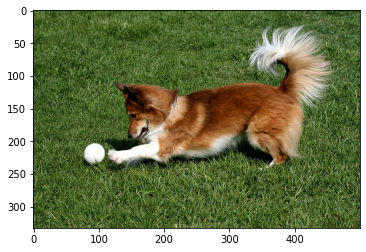

------------------------ Actual ------------------------
start  black and white dog is jumping over hurdle  end
start  black and white dog jumps over bar in an agility test  end
start  dog jumps over hurdle on grass field  end
start  dog leaps over bar on an obstacle course  end
start  the black and white dog jumps over an obstacle  end
---------------------- Prediction ----------------------
start black and white dog jumps over hurdle end


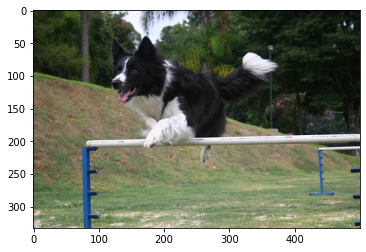

------------------------ Actual ------------------------
start  "a boy in life jacket jumps onto something yellow out of frame ."  end
start  boy wearing life vest suspended in the air  end
start  "a child wearing white red and black life jacket was bounced into the air by something big and yellow ."  end
start  child with floatation vest is being bounced off of something  end
start  the kid in the life vest jumps up in the air  end
---------------------- Prediction ----------------------
start girl in blue and green costume is falling backwards end


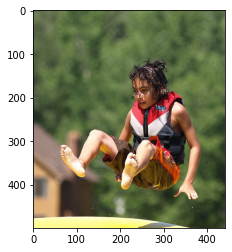

------------------------ Actual ------------------------
start  two brown and white dogs fighting over frisbee  end
start  two dogs fighting over frisbee  end
start  two dogs outside fighting over red frisbee  end
start  two dogs play with frisbee on the lawn  end
start  two dogs try to get the chewed-up red frisbee from the other  end
---------------------- Prediction ----------------------
start dog biting another dog end


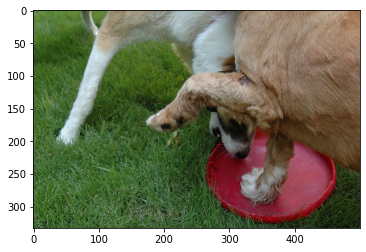

------------------------ Actual ------------------------
start  man dressing in black shirt is waiting to cross the street with traffic  end
start  man standing in crosswalk  end
start  man waiting for traffic to stop at road crossing  end
start  an asian man tries to jaywalk on street with heavy traffic  end
start  man waits for taxis to pass before crossing the wet road  end
---------------------- Prediction ----------------------
start woman walking down busy street end


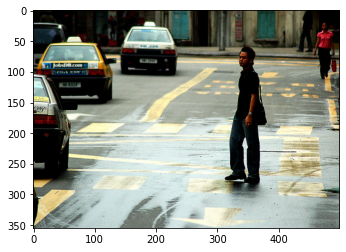

In [85]:
for _ in range(5):
    random = np.random.randint(0, len(test))
    random_id = test[random]
    generate_caption(model, random_id, images_path)